adapted from <https://developmentalsystems.org/sensorimotor-lenia/>


In [1]:
import time

from IPython.display import Image as IPImage
from IPython.display import display
import cv2
import imageio
import matplotlib.cm as cm
import numpy as np
import torch

from pylib.difflenia._LeniaInitializationSpace import LeniaInitializationSpace
from pylib.difflenia._Lenia_C import Lenia_C
from pylib.difflenia._VideoWriter import VideoWriter

torch.set_default_tensor_type("torch.FloatTensor")


In [2]:
system = Lenia_C(nb_k=5)
system.config.final_step = 200

with torch.no_grad():
    for _ in range(4):
        # the method system.reset() sets random parameters for Lenia update rule, unless update_rule_parameters are passed as argument
        system.reset()
        # the method system.generate_init_state() allows to generate a random intialization square in all channels (but you can replace it by setting yourself the system.state)
        system.random_obstacle(0)
        system.generate_init_state()
        # the method system.run() launches a rollout in Lenia
        observations = system.run()

        with VideoWriter("out.mp4", 30.0) as vid:
            for timestep in range(observations["states"].shape[0]):

                rgb_im = (
                    observations.states[timestep, :, :, 0]
                    .detach()
                    .cpu()
                    .numpy()
                )

                vid.add(rgb_im)
            vid.show()


/home/runner/work/hstrat-agentless-concept/hstrat-agentless-concept/binder/pylib/difflenia/_LeniaStepFFTC.py:124: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at ../aten/src/ATen/native/Copy.cpp:276.)
  self.kernels[i] = kernel_FFT


bypassing output
bypassing output
bypassing output
bypassing output


In [3]:
# 3 examples of discovered creatures (1 channel and 10 rules)

!wget  'https://osf.io/tqxhu/download' -O 'crea1.pickle'
!wget  'https://osf.io/tqfwk/download' -O 'crea2.pickle'
!wget  'https://osf.io/ba536/download' -O 'crea3.pickle'


--2025-03-20 19:06:15--  https://osf.io/tqxhu/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1 [following]
--2025-03-20 19:06:15--  https://files.osf.io/v1/resources/fj8u6/providers/osfstorage/67dc35d277ab6a0debc6ff94?action=download&direct&version=1
Resolving files.osf.io (files.osf.io)... 35.186.214.196
Connecting to files.osf.io (files.osf.io)|35.186.214.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12214 (12K) [application/octet-stream]
Saving to: ‘crea1.pickle’

crea1.pickle        100%[===================>]  11.93K  --.-KB/s    in 0s      

2025-03-20 19:06:17 (65.5 MB/s) - ‘crea1.pickle’ saved [12214/12214]

--2025-03-20 19:06:17--  https://osf.io/tqfwk/download
Resolving osf.io (osf.io)... 35.190.84.173
Co

Running Lenia simulation...
Simulation completed in 1.39 seconds.


/tmp/ipykernel_4512/1382590167.py:105: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("jet")


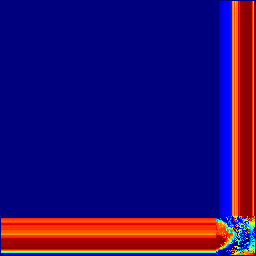

In [4]:
# Ensure the device is defined
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def main(
    SX,
    SY,
    mode="random",
    borders=False,
    list_kernels=range(10),
    creaFile="crea1.pickle",
    modeb="none",
    zoom=1,
):
    # Configure the simulation
    lenia_config = Lenia_C.default_config()
    lenia_config.SX = SX
    lenia_config.SY = SY
    lenia_config.final_step = 200  # number of timesteps
    lenia_config.version = "pytorch_fft"
    lenia_config.nb_kernels = len(list_kernels)

    # Create the initialization space and system
    initialization_space_config = {}  # use a plain dict for simplicity
    initialization_space = LeniaInitializationSpace(
        config=initialization_space_config
    )
    system = Lenia_C(
        initialization_space=initialization_space,
        config=lenia_config,
        device=device,
    )

    # Load initial configuration from file
    a = torch.load(creaFile, map_location=device)
    policy_parameters = {}
    policy_parameters["initialization"] = a["policy_parameters"][
        "initialization"
    ]
    policy_parameters["update_rule"] = a["policy_parameters"]["update_rule"]
    policy_parameters["update_rule"]["R"] = (
        policy_parameters["update_rule"]["R"] + 15
    ) * zoom - 15

    # For each update rule parameter (except R and T), select the desired kernels and move them to device
    for k in policy_parameters["update_rule"].keys():
        if k not in ["R", "T"]:
            policy_parameters["update_rule"][k] = policy_parameters[
                "update_rule"
            ][k][list_kernels]
        policy_parameters["update_rule"][k] = policy_parameters["update_rule"][
            k
        ].to(device)

    # Prepare the initial state image from the initialization parameters
    init_s = (
        policy_parameters["initialization"]
        .init.cpu()
        .numpy()
        .astype(np.float32)
    )
    width = int(init_s.shape[1] * zoom)
    height = int(init_s.shape[0] * zoom)
    # Resize image using OpenCV (note: cv2.resize expects (width, height))
    init_f = cv2.resize(init_s, (width, height))
    init_f = torch.tensor(init_f).to(device)

    # Reset the system with the loaded parameters
    system.reset(
        initialization_parameters=policy_parameters["initialization"],
        update_rule_parameters=policy_parameters["update_rule"],
    )

    # In random mode, add obstacles automatically (no interactive drawing)
    if mode == "random":
        system.random_obstacle()

    # Optionally add border walls
    if borders:
        system.init_wall[:, :4] = 1
        system.init_wall[:, -4:] = 1
        system.init_wall[-4:, :] = 1
        system.init_wall[:4, :] = 1

    system.init_loca = []
    for i in range(1, SX - 40):
        for j in range(1, SY - 40):
            system.init_loca.append((i, j))

    print("Running Lenia simulation...")
    t0 = time.time()
    with torch.no_grad():
        system.generate_init_state()
        # Insert the initial configuration image into the simulation state
        for loca in system.init_loca:
            x, y = loca
            system.state[
                0, x : x + init_f.shape[0], y : y + init_f.shape[1], 0
            ] = init_f
        observations = system.run()
    sim_time = time.time() - t0
    print(f"Simulation completed in {sim_time:.2f} seconds.")

    # Create a GIF from the simulation observations.
    cmap = cm.get_cmap("jet")
    fps = 30.0  # Frames per second for the GIF
    frames = []
    for t in range(observations["states"].shape[0]):
        # Extract the first channel of the state at timestep t
        state = observations["states"][t, :, :, 0].detach().cpu().numpy()
        # Normalize the state to [0, 1]
        norm_state = (state - state.min()) / (state.max() - state.min() + 1e-8)
        # Apply colormap and convert to an 8-bit RGB image
        rgb_frame = (cmap(norm_state)[:, :, :3] * 255).astype(np.uint8)
        frames.append(rgb_frame)

    gif_filename = "out.gif"
    imageio.mimsave(gif_filename, frames, fps=fps)

    # Display the GIF inline in the notebook
    display(IPImage(filename=gif_filename))


# Run the simulation with chosen parameters
SX = 256
SY = 256
mode = "random"  # non-interactive mode
modeb = "none"
borders = False
creature = (
    "crea2"  # filename (without extension) for the initial configuration
)
main(
    SX,
    SY,
    mode,
    borders,
    list(range(10)),
    creaFile=creature + ".pickle",
    modeb=modeb,
    zoom=1,
)
